In [1]:
import sys
sys.path.append("../../../smsl")

In [2]:
import MDAnalysis as mda
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from smsl.config import load_config
import glob

conf_file = glob.glob('../../d.fluctmatch/*.conf')[0]
conf = load_config(conf_file, verbose=False)
df_tetrad_geometry = conf['df_tetrad_geometry']
df_tetrad_geometry

,Q3,Q2,Q1,Q4
top,2,8,14,20
mid,3,9,15,21
bot,4,10,16,22


In [24]:
jobname = conf['system']
jobname

'propeller'

### Load Trajectory

In [5]:
u = mda.Universe('../1.create_system/npt2_noh.pdb', f'{jobname}_5us500kf_noh.xtc')

In [6]:
u.transfer_to_memory(verbose=1)

Loading frames:   0%|          | 0/5001 [00:00<?, ?it/s]

In [7]:
## **注意！ 這邊看到的K2在上層 K1在下層**
k1 = u.select_atoms('resid 1 and name K').ix[0]
k2 = u.select_atoms('resid 2 and name K').ix[0]
ks = u.select_atoms('name K and not (resid 2)').ix ##為了替換下層鉀離子用，因為不希望替換成上層K2(這樣就變成K1和K2都是上層鉀離子)因此去除

In [8]:
coord = u.trajectory.timeseries()
coord = np.transpose(coord, [1, 0, 2]) ##since using `transfer_to_memory` will swap these 2 dims

In [9]:
coord.shape

(5001, 756, 3)

### check Distance Between DNA - K^+
if >15 Å it means the ion is out of coordination site or the PBC isn't remove correctly

In [10]:
time_label = [f*u.trajectory.dt/1000 for f in range(len(u.trajectory))]

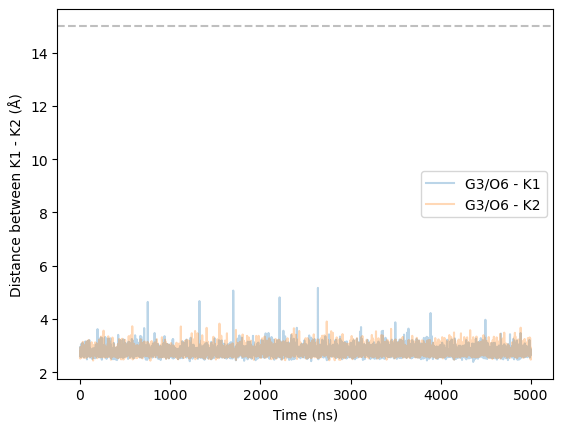

In [11]:
## **注意！ 這邊看到的K2在上層 K1在下層**
dna_G3_O6 = u.select_atoms('resname DG and name O6').ix[1]
dist_dnak1 = np.linalg.norm(coord[:,dna_G3_O6,:] - coord[:,k1,:], axis=1)
dist_dnak2 = np.linalg.norm(coord[:,dna_G3_O6,:] - coord[:,k2,:], axis=1)
plt.plot(time_label, dist_dnak1, label='G3/O6 - K1', alpha=0.3)
plt.plot(time_label, dist_dnak2, label='G3/O6 - K2', alpha=0.3)
plt.axhline(15.0, color='gray', alpha=0.5, linestyle='--')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel(r'Distance between K1 - K2 (Å)')
plt.show()

### Check Distance Between K1 - K2
3.0 ~ 5.0 Å is considered as the ion in the coordination site<br>
if >15 Å it means the ion is out of coordination site or the PBC isn't remove correctly

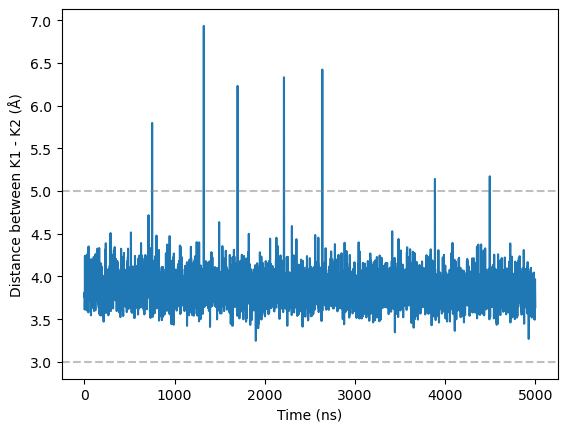

In [12]:
dist_k1k2 = np.linalg.norm(coord[:,k1,:] - coord[:,k2,:], axis=1)
plt.plot(time_label, dist_k1k2)
plt.axhline(3.0, color='gray', alpha=0.5, linestyle='--')
plt.axhline(5.0, color='gray', alpha=0.5, linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel(r'Distance between K1 - K2 (Å)')
plt.show()

In [13]:
if dist_k1k2.max() > 15:
    print('K1 or K2 is out of the coordination site, need to found the nearest ion in K hole')
else:
    raise RuntimeError('K1 or K2 is in the coordination site, there is not need to do the following precess, go to run d.fluctmatch')

RuntimeError: K1 or K2 is in the coordination site, there is not need to do the following precess, go to run d.fluctmatch

### Search The nearest ion in K2 hole

In [14]:
O6_Mid = u.select_atoms("resid "+' '.join(df_tetrad_geometry.T['mid'].astype('str'))+" and name O6").ix
O6_Bot = u.select_atoms("resid "+' '.join(df_tetrad_geometry.T['bot'].astype('str'))+" and name O6").ix
all_ixs = np.concatenate([O6_Mid, O6_Bot])
k_hole_coord = coord[:,all_ixs,:].mean(axis=1)

In [15]:
k_min_coord = []
k_min_list = []
for idx, time in enumerate(tqdm(time_label)):
    coord_ks_1frame = coord[idx, ks,:]
    k_hole_1frame  = np.expand_dims(k_hole_coord[idx, :], 0)
    dist_k_hole_ks = np.linalg.norm(coord_ks_1frame - k_hole_1frame, axis=1)
    k_min = ks[np.argmin(dist_k_hole_ks)]
    k_min_coo = coord[idx, k_min, :]
    k_min_coord.append(k_min_coo)
    k_min_list.append(k_min)
k_min_coord = np.array(k_min_coord)
k_min_list = np.array(k_min_list)

100%|██████████| 5001/5001 [00:00<00:00, 72191.39it/s]


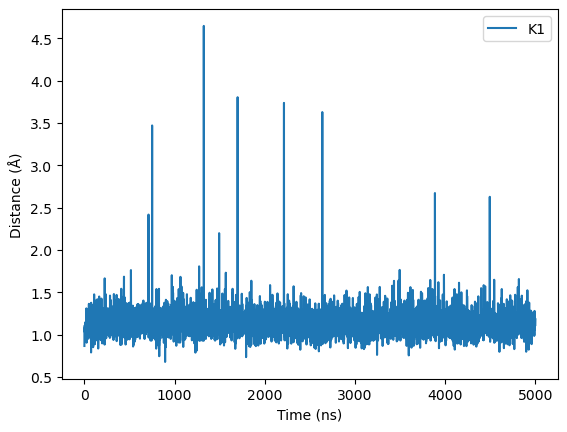

In [16]:
k_min2coord = {}
for k_min in np.unique(k_min_list):
    time_label_sele = np.array(time_label)[k_min_list==k_min]
    k_min_coord_sele = k_min_coord[k_min_list==k_min]
    k_hole_coord_sele = k_hole_coord[k_min_list==k_min]
    dist_sele = np.linalg.norm(k_min_coord_sele - k_hole_coord_sele, axis=1)
    k_min2coord[k_min] = [time_label_sele, dist_sele]
    
for k_min, [time_label_sele, dist] in k_min2coord.items():
    plt.plot(time_label_sele, dist, label=f'K{u.atoms[k_min].resid}')
plt.xlabel('Time (ns)')
plt.ylabel('Distance (Å)')
plt.legend()
plt.show()

### Replace K_min position with K1(下層)
**(only if you found that the ion is out of the coordinate site)**

In [17]:
for idx, k_min_coo in enumerate(tqdm(k_min_coord)):
    u.trajectory[idx].positions[k1, :] = k_min_coo

100%|██████████| 5001/5001 [00:00<00:00, 203113.31it/s]


In [18]:
coord = u.trajectory.timeseries()
coord = np.transpose(coord, [1, 0, 2]) ##since using `transfer_to_memory` will swap these 2 dims

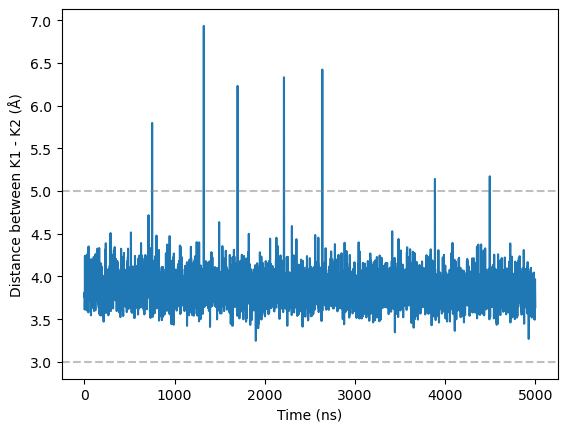

In [19]:
## check again the K1-K2 distance after replace
dist_k1k2 = np.linalg.norm(coord[:,k1,:] - coord[:,k2,:], axis=1)
plt.plot(time_label, dist_k1k2)
plt.axhline(3.0, color='gray', alpha=0.5, linestyle='--')
plt.axhline(5.0, color='gray', alpha=0.5, linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel(r'Distance between K1 - K2 (Å)')
plt.show()

### Write Data

In [20]:
ag_model = u.select_atoms('nucleic or (resid 1-2 and name K)')
ag_model.write(f'{jobname}_5us500kf.k_min.xtc', frames='all')

In [21]:
!gmx trjconv -f {jobname}_5us500kf.k_min.xtc -o {jobname}_5us5kf.k_min.xtc -skip 100 -ndec 5

                     :-) GROMACS - gmx trjconv, 2023.2 (-:

Executable:   /home/user/opt/gromacs-2023/bin/gmx
Data prefix:  /home/user/opt/gromacs-2023
Working dir:  /home/user/workfolder/g4dna_protocol_demo/propeller/c.gromacs.run_md/2.simulation
Command line:
  gmx trjconv -f 1kf1_5us500kf.k_min.xtc -o 1kf1_5us5kf.k_min.xtc -skip 100 -ndec 5

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading frame       0 time    0.000   
Precision of 1kf1_5us500kf.k_min.xtc is 0.001 (nm)

Setting output precision to 1e-05 (nm)
Last frame       5000 time 5000000.000     frame      0 time    0.000      
 ->  frame     50 time 5000000.000      
Last written: frame     50 time 5000000.000


GROMACS reminds you: "It's just the way this stuff is done" (Built to Spill)



In [ ]:
!cp {jobname}_5us500kf.k_min.xtc {jobname}_5us5kf.k_min.xtc ../3.trajectory_data